# Data Preparation

In [0]:
#enable tf_eager_execution to transfer tensor into nampy array
import tensorflow as tf
tf.enable_eager_execution()

In [0]:
from google.colab import drive
drive.mount('/content/drive')
#allaeddine.guissous@gmail.com account contain the dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# download the data
#!wget https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_Input.zip


In [0]:
#Extract the data
#!unzip ISIC_2019_Training_Input.zip

import zipfile
import time
start = time.time()
with zipfile.ZipFile("drive/My Drive/ISIC_2019_Training_Input.zip","r") as zip_ref:
    zip_ref.extractall()

end = time.time()
elapsed = end - start
print(elapsed)

142.22045803070068


In [0]:
#delete non images files
!rm ISIC_2019_Training_Input/ATTRIBUTION.txt
!rm ISIC_2019_Training_Input/LICENSE.txt

In [0]:
#import necessary libraries
import pandas as pd
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


# Read in the data
ground_truth = pd.read_csv('https://s3.amazonaws.com/isic-challenge-2019/ISIC_2019_Training_GroundTruth.csv')

# Display some information in the dataset
ground_truth.head()


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
# Set y as the labels
y = []
for row in ground_truth.iterrows():
    innerlist = []
    newlist = row[1].index[row[1].values[1:].argmax() + 1]
    y.append(newlist)
#add a name to the label series
yd = pd.Series(y) 
yd.name = 'cclass'

In [0]:
# Split the metadata into training and validation
df_train, df_val = train_test_split(ground_truth, test_size=0.17, random_state=101, stratify=yd)

In [0]:
# Get a list of images in each of the two folders
folder = os.listdir('ISIC_2019_Training_Input')

# Get a list of train and val images
#all_list = list(ground_truth['image'])
#
train_list = list(df_train['image'])
val_list = list(df_val['image'])

# color_constancy

In [0]:
# !rm -r ISIC_2019_Training_Input2
# !rm -r base_dir

In [0]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

def gray_world(img):
    """
    Parameters
    ----------
    img: 2D numpy array
        The original image with format of (h, w, c)
    """
    img = img.astype(np.float)
    pixels_num = img.shape[0] * img.shape[1]
    bgr_avg = np.sum(np.sum(img, axis = 0), axis = 0) / pixels_num
    gray_avg = np.sum(bgr_avg) / img.shape[2]
    bgr_k = gray_avg / bgr_avg
    return img * np.transpose(bgr_k)
def white_patch_retinex(img, para):
    """
    Parameters
    ----------
    img: 2D numpy array
        The original image with format of (h, w, c)
    para: 0 or 1
        0 : original algorithm
        1 : optimization algorithm
    """
    img = img.astype(np.float)
    out = np.zeros(img.shape, dtype=float)
    L = [0, 0, 0]
    if para == 0:
        for i in range(3):
            L[i] = np.max(img[:, :, i].flatten())
            out[:, :, i] = img[:, :, i] * 255.0 / L[i]
    elif para == 1:
        n_p = 0.1 * img.shape[0] * img.shape[1]
        for i in range(3):
            H, bins = np.histogram(img[:, :, i].flatten(), 256)
            sums = 0
            for j in range(255, -1, -1):
                if sums < n_p:
                    sums += H[j]
                else:
                    L[i] = j
                    out[:, :, i] = img[:, :, i] * 255.0 / L[i]
                    break
    return out
def shade_of_gray(img, power=6, gamma=None):
    """
    Parameters
    ----------
    img: 2D numpy array
        The original image with format of (h, w, c)
    power: int
        The degree of norm, 6 is used in reference paper
    gamma: float
        The value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in xrange(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    return img.astype(img_dtype)
def general_gray_world(img, power=2, sigma=3):
    """
    Parameters
    ----------
    img: 2D numpy array
        The original image with format of (h, w, c)
    power: int
        The degree of norm, 2 is used in reference paper
    sigma: float
        Filtering image with a Guassian low-pass filter with standard deviation sigma
    """
    blur = cv2.GaussianBlur(img, (3, 3), sigma)
    return shade_of_gray(blur, power)
  


In [0]:
len(os.listdir('ISIC_2019_Training_Input'))

25331

In [0]:
!rm -r ISIC_2019_Training_Input2

In [0]:
import cv2 as cv
import os
#import process_bar
import sys
import time
start = time.time()
from IPython.display import clear_output

width = 600 
height = 450

data_dir = 'ISIC_2019_Training_Input'
#data_dir = '../data/ISIC2018/ISIC2018_Task3_Validation_Input/'
#for cnt in [2,5,8,9]:
#cnt = int(sys.argv[1])
#output_dir = '../data/valid_{}'.format(cnt)
#output_dir = './valid_wpr1'
output_dir = 'ISIC_2019_Training_Input2'
os.makedirs(output_dir, exist_ok=True)
#print('-----{}-----'.format(cnt))
cpt = 0
done = 0
#process_bar_ = process_bar.process_bar(195)
for img in os.listdir(data_dir):
    if img.split('.')[-1] != 'jpg':
        continue
    image_path = os.path.join(data_dir, img)
    image_np = cv.imread(image_path)
    image_np =cv2.resize(image_np,(width,height)) 
   
    #new_image_np = shade_of_gray(image_np, power=cnt)
    new_image_np = white_patch_retinex(image_np, 1)
    output_path = os.path.join(output_dir, img)
    #print(output_path)
    cv.imwrite(output_path,new_image_np)
    #process_bar_.show_process()
    cpt =  cpt + 1
    if cpt == 1000:
      done = done + 1000
      clear_output()
      print(25331-done,' remaining')
     
      cpt = 0

end = time.time()
elapsed = end - start
print(elapsed)      

331  remaining
1119.4610006809235


# visualize color constancy


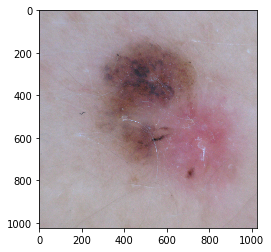

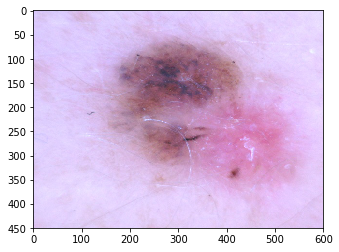

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread(image_path)
image2 = mpimg.imread(output_path)
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

# create a work directory

In [0]:
!rm -r base_dir

In [0]:
base_dir = 'base_dir'
train_dir = os.path.join(base_dir, 'train_dir')
val_dir = os.path.join(base_dir, 'val_dir')

In [0]:
#create a work directory
base_dir = 'base_dir'
os.mkdir(base_dir)

# Training files directory
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# Validation files directory
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


In [0]:
#create sub directory for the classes
for col in ground_truth.columns:
    if not (col == 'image' or  col == 'UNK'):
        dir_path = os.path.join(train_dir, col)
        os.mkdir(dir_path)
        dir_path = os.path.join(val_dir, col)
        os.mkdir(dir_path)

In [0]:
#check the directories
!ls ./base_dir/val_dir/

AK  BCC  BKL  DF  MEL  NV  SCC	VASC


In [0]:
main_dir = 'ISIC_2019_Training_Input2'

# Transfer the images into the folders


In [0]:
# Transfer the training images
for row in df_train.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join(main_dir, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        


In [0]:
# Transfer the training images
for row in df_val.iterrows():
    image = row[1].image
    # The argmax error was occuring because the first column (image) is a string.
    # By using row[1].values[1:] we skip the first column.  This means we need 
    # add 1 to get the correct row[1].index.
    label = row[1].index[row[1].values[1:].argmax() + 1]
    fname = image + '.jpg'

    if fname in folder:
        # source path to image
        src = os.path.join(main_dir, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

**length of training and validation examples**

In [0]:
# validation examples
total = 0
train_list = os.listdir(train_dir)
for col in train_list:
        npath = os.path.join(val_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        

AK 147
SCC 107
MEL 769
BKL 446
BCC 565
DF 41
VASC 43
NV 2189
total =  4307


In [0]:
# training examples
total = 0
val_list = os.listdir(train_dir)
for col in val_list:
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)     

AK 720
SCC 521
MEL 3753
BKL 2178
BCC 2758
DF 198
VASC 210
NV 10686
total =  21024


In [0]:
file_paths = []

In [0]:
import os

for dirname, dirnames, filenames in os.walk('base_dir'):
    # print path to all subdirectories first.
    #for subdirname in dirnames:
        #print(os.path.join(dirname, subdirname))

    # print path to all filenames.
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        file_paths.append(os.path.join(dirname, filename))

    # Advanced usage:
    # editing the 'dirnames' list will stop os.walk() from recursing into there.
    if '.git' in dirnames:
        # don't go into any .git directories.
        dirnames.remove('.git')

In [0]:
file_paths

['base_dir/val_dir/AK/ISIC_0067266.jpg',
 'base_dir/val_dir/AK/ISIC_0071015.jpg',
 'base_dir/val_dir/AK/ISIC_0065404.jpg',
 'base_dir/val_dir/AK/ISIC_0060357.jpg',
 'base_dir/val_dir/AK/ISIC_0071779.jpg',
 'base_dir/val_dir/AK/ISIC_0059852.jpg',
 'base_dir/val_dir/AK/ISIC_0062953.jpg',
 'base_dir/val_dir/AK/ISIC_0059799.jpg',
 'base_dir/val_dir/AK/ISIC_0058939.jpg',
 'base_dir/val_dir/AK/ISIC_0071256.jpg',
 'base_dir/val_dir/AK/ISIC_0058951.jpg',
 'base_dir/val_dir/AK/ISIC_0057351.jpg',
 'base_dir/val_dir/AK/ISIC_0067177.jpg',
 'base_dir/val_dir/AK/ISIC_0031506.jpg',
 'base_dir/val_dir/AK/ISIC_0059058.jpg',
 'base_dir/val_dir/AK/ISIC_0059985.jpg',
 'base_dir/val_dir/AK/ISIC_0030242.jpg',
 'base_dir/val_dir/AK/ISIC_0062104.jpg',
 'base_dir/val_dir/AK/ISIC_0024646.jpg',
 'base_dir/val_dir/AK/ISIC_0063536.jpg',
 'base_dir/val_dir/AK/ISIC_0060480.jpg',
 'base_dir/val_dir/AK/ISIC_0056582.jpg',
 'base_dir/val_dir/AK/ISIC_0056867.jpg',
 'base_dir/val_dir/AK/ISIC_0065628.jpg',
 'base_dir/val_d

In [0]:
!rm -r drive/My Drive/drive2/base_dir

rm: cannot remove 'drive/My': No such file or directory
rm: cannot remove 'Drive/drive2/base_dir': No such file or directory


In [0]:
import zipfile
from zipfile import ZipFile 
import os 

# writing files to a zipfile 
with ZipFile('base_dir.zip','w') as zip: 
# writing each file one by one 
  for file in file_paths: 
      zip.write(file) 

In [0]:
!cp -r base_dir -d 'drive/My Drive/drive2'
!cp  base_dir.zip -d 'drive/My Drive/drive2'

# Balance the training an validation data

## Balancing the val data

In [0]:
import os, random
fldlist = os.listdir('base_dir/val_dir')
mellen = len(os.listdir('base_dir/val_dir/DF'))
for fld in fldlist:
      for i in range(len(os.listdir(os.path.join(val_dir,fld)))-mellen):
          file = random.choice(os.listdir(os.path.join(val_dir,fld)))
          dst = os.path.join(val_dir,fld, file)
          os.remove(dst)

In [0]:
total = 0
train_list = os.listdir(val_dir)
for col in train_list:
        npath = os.path.join(val_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total)        
val_len = total

BCC 48
DF 48
BKL 48
MEL 48
AK 48
NV 48
SCC 48
VASC 48
total =  384


## Balancing the train data

In [0]:
import os, random
mellen = len(os.listdir('base_dir/train_dir/BCC'))
nvlen = len(os.listdir('base_dir/train_dir/NV'))
for i in range(nvlen - mellen):
    file = random.choice(os.listdir("base_dir/train_dir/NV"))
    dst = os.path.join(train_dir,'NV', file)
    os.remove(dst)

In [0]:
# training examples
total = 0
train_list = os.listdir(train_dir)
for col in train_list:
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total) 
train_len = total

BCC 2658
DF 191
BKL 2099
MEL 3618
AK 694
NV 2658
SCC 502
VASC 202
total =  12622


## generate new images


In [0]:
!rm -r base_dir/train_dir2

In [0]:
# Training file directory
train_dir2 = os.path.join(base_dir, 'train_dir2')
os.mkdir(train_dir2)

val_list = os.listdir(train_dir)
for col in val_list:
        dir_path = os.path.join(train_dir2, col)
        os.mkdir(dir_path)

In [0]:
import cv2
def crop_center(img,cropx,cropy):
  x = 320
  y = 320
  startx = x//2-(cropx//2)
  starty = y//2-(cropy//2)    
  return img[starty:starty+cropy,startx:startx+cropx]

def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

#         # random crop
#         #img = tf.random_crop(img, [224, 224, 3])
#         # flip
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_flip_up_down(img)
#         with tf.Session() as sess:
#           sess.run(tf.constant(img))
#           img = tf.constant(img).eval ()

In [0]:

from IPython.display import clear_output
from random import randint
#crop_center all images in train dir and move the result to train_dir2
width = 320
train_fld = os.listdir (train_dir)
done = 0
for subfld in train_fld:
    class_dir = os.path.join(train_dir,subfld)
    dst_class_dir = os.path.join(train_dir2,subfld)
    temp_img = os.listdir (class_dir)    
    if '.ipynb_checkpoints' in temp_img:
        temp_img.remove('.ipynb_checkpoints')
        !rm -r temp_img +'.ipynb_checkpoints' 
    cpt = 0 
    img_len = int(len(temp_img))
    for nb in range(img_len):
        img=cv2.imread(class_dir + '/' + temp_img[nb])
        img=cv2.resize(img,(width,width)) 
        img = crop_center(img,224,224)
        angle = randint(10, 180)
        img = rotateImage(img, angle)
        #img = cv2.flip(img,0)
        iname =os.path.join(dst_class_dir,str(nb) +'croped224.jpg')
        cv2.imwrite(iname, img)
        cpt =  cpt + 1
        if cpt == 1000:
          done = done + 1000
          clear_output()
          print(12622-done,' remaining')
          cpt = 0
        
        

3622  remaining


In [0]:
# training examples
total = 0
train_list = os.listdir(train_dir2)
for col in train_list:
        npath = os.path.join(train_dir2, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total) 
train_len = total

BCC 2658
DF 191
BKL 2099
MEL 3618
AK 694
NV 2658
SCC 502
VASC 202
total =  12622


In [0]:
# # Training file directory
# train_dir3 = os.path.join(base_dir, 'train_dir3')
# os.mkdir(train_dir3)

# val_list = os.listdir(train_dir)
# for col in val_list:
#         dir_path = os.path.join(train_dir3, col)
#         os.mkdir(dir_path)

In [0]:
# !pip install image_slicer

In [0]:
# # slicing one image to 4 blocks for th minority  classes 
# #train_dir2 contain slices + original
# import image_slicer
# import shutil
# import os

# #train_fld = os.listdir (train_dir2)
# #train_fld =['MEL', 'BKL', 'BCC', 'SCC', 'VASC', 'DF', 'AK','NV']
# train_fld =['SCC', 'VASC', 'DF', 'AK']
# for subfld in train_fld:
#       class_dir = os.path.join(train_dir2,subfld)
#       #dst_class_dir = os.path.join(train_dir3,subfld)
#       temp_img = os.listdir (class_dir)
#       if '.ipynb_checkpoints' in temp_img:
#           temp_img.remove('.ipynb_checkpoints')
#       for nb in range((int(len(temp_img)))):
#           image_slicer.slice(class_dir +'/'+ temp_img[nb], 4)
#           #move to train_dir3
#           #shutil.move(class_dir +'/'+ temp_img[nb] , dst_class_dir +'/'+ temp_img[nb] )
#           #delete the original images
#           #original_img = class_dir +'/'+ temp_img[nb]
#           #os.remove(original_img) 
#           # the rest original are the resized images

In [0]:
# shuffl and move images from trrain_dir2 to base_dir
import os, random
#train_fld = os.listdir (train_dir2)
#train_fld =['MEL', 'BKL', 'BCC', 'SCC', 'VASC', 'DF', 'AK','NV']
train_fld =['SCC', 'VASC', 'DF', 'AK']
for subfld in train_fld:
    class_dir = os.path.join(train_dir2,subfld)
    temp_img = os.listdir (class_dir)
    #if subfld != 'NV':
    for nb in range((int(len(temp_img)))):
            file = random.choice(temp_img)
            src = os.path.join(class_dir, file)
            class_dir_dst = os.path.join(train_dir,subfld)
            dst = os.path.join(class_dir_dst, str(nb) + '_shuffl.jpg')
            shutil.move(src ,dst)
            temp_img.remove(str(file)) 
# after the orperation is done the train_dir2 folder will end up empty          

In [0]:
# !cp -r base_dir/train_dir2/AK -d base_dir/train_dir
# !cp -r base_dir/train_dir2/DF -d base_dir/train_dir
# !cp -r base_dir/train_dir2/SCC -d base_dir/train_dir
# !cp -r base_dir/train_dir2/VASC -d base_dir/train_dir
# !cp -r base_dir/train_dir2/BCC -d base_dir/train_dir
# !cp -r base_dir/train_dir2/BKL -d base_dir/train_dir
# !cp -r base_dir/train_dir2/MEL -d base_dir/train_dir
# !cp -r base_dir/train_dir2/NV -d base_dir/train_dir

# !cp -r base_dir/train_dir3/AK -d base_dir/train_dir
# !cp -r base_dir/train_dir3/DF -d base_dir/train_dir
# !cp -r base_dir/train_dir3/SCC -d base_dir/train_dir
# !cp -r base_dir/train_dir3/VASC -d base_dir/train_dir
# !cp -r base_dir/train_dir3/BCC -d base_dir/train_dir
# !cp -r base_dir/train_dir3/BKL -d base_dir/train_dir
# !cp -r base_dir/train_dir3/MEL -d base_dir/train_dir
# !cp -r base_dir/train_dir3/NV -d base_dir/train_dir

In [0]:
# training examples
total = 0
train_list = os.listdir(train_dir)
for col in train_list:
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total) 
train_len = total

BCC 2658
DF 382
BKL 2099
MEL 3618
AK 1388
NV 2658
SCC 1003
VASC 404
total =  14210


# Augment the training data

In [0]:
# 
# Classes 'nv', 'MEL', 'BKL', 'BCC' is not going to be augmented
class_list = ['MEL', 'BKL', 'BCC', 'SCC', 'VASC', 'DF', 'AK','NV']
#class_list = [ 'SCC', 'VASC', 'DF', 'AK']
for item in class_list:

    # Create a temporary directory for the augmented images
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)

    # Create a directory within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # List all the images in the directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for fname in img_list:
        # source path to image
        src = os.path.join('base_dir/train_dir/' + img_class, fname)
        # destination path to image
        dst = os.path.join(img_dir, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator to augment the images in real time
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range= 0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                              save_to_dir=save_path,
                                              save_format='jpg',
                                              target_size=(224, 224),
                                              batch_size=batch_size)

    # Generate the augmented images and add them to the training folders
    num_aug_images_wanted = 6000  # total number of images we want to have in each class
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted - num_files) / batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)

    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 3618 images belonging to 1 classes.
Found 2099 images belonging to 1 classes.
Found 2658 images belonging to 1 classes.
Found 1003 images belonging to 1 classes.
Found 404 images belonging to 1 classes.
Found 382 images belonging to 1 classes.
Found 1388 images belonging to 1 classes.
Found 2658 images belonging to 1 classes.


## Visualize 50 augmented images

In [0]:
# training examples
total = 0
train_list = os.listdir(train_dir)
for col in train_list:
        npath = os.path.join(train_dir, col)
        print(col,len(os.listdir(npath)))
        total = total+len(os.listdir(npath))
print('total = ',total) 
train_len = total

BCC 5966
DF 5780
BKL 6048
MEL 6018
AK 6002
NV 5966
SCC 5815
VASC 5452
total =  47047


In [0]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import imageio as im
from keras.preprocessing import image

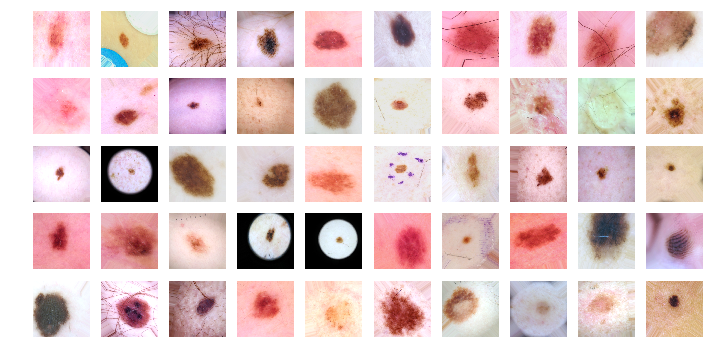

In [0]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) # titles=labels will display the image labels

In [0]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

# Building the model

In [0]:
# Import the libraries
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

from keras import layers
from keras import Model
from keras.models import Sequential
from keras.layers import Activation


from keras.metrics import categorical_crossentropy

from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.applications.densenet import DenseNet201, preprocess_input
#from keras.applications.nasnet.NASNetLarge import NASNetLarge, preprocess_input
%matplotlib inline


## summary on the full model

In [0]:
#densenet_model = DenseNet201(input_shape=(224, 224, 3), include_top=True, weights="imagenet")

In [0]:
#type(densenet_model)

In [0]:
#densenet_model.summary()

## editing the model

In [0]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

In [0]:
densenet_model = DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
densenet_model.summary()

W0701 12:34:17.183161 140666916284288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 12:34:17.242334 140666916284288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 12:34:17.243973 140666916284288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0701 12:34:19.059407 140666916284288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0701 12:34:19.151104 1406

74842112/74836368 [==============================] - 7s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________

In [0]:
# for layer in densenet_model.layers:
#     print(layer.name)
#     if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
#         layer.trainable = True
#         K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
#         K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
#     else:
#         layer.trainable = False

# print(len(densenet_model.layers))
# lastlayername = layer

In [0]:
# The paths for the training and validation images
train_path = 'base_dir/train_dir'
val_path = 'base_dir/val_dir'

In [0]:
# Declare a few useful values
num_train_samples = train_len
num_val_samples = val_len
train_batch_size = 16
val_batch_size = 64
image_height = 224
image_width = 224

In [0]:
print(val_len)
print(train_len)

384
47047


In [0]:
# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [0]:
# Set up generators

datagenr = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.densenet.preprocess_input)


train_batches = datagenr.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    batch_size=train_batch_size)

val_batches = datagenr.flow_from_directory(
    val_path,
    target_size=(image_height, image_width),
    batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagenr.flow_from_directory(
    val_path,
    target_size=(image_height, image_width),
    batch_size=val_batch_size,
    shuffle=False)

Found 47047 images belonging to 8 classes.
Found 384 images belonging to 8 classes.
Found 384 images belonging to 8 classes.


**architecture 1**

In [0]:
#get the last layer shape
last_layer = densenet_model.get_layer('relu')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 1920)


In [0]:

# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
#x = layers.MaxPooling2D(pool_size=2,strides=None, padding='same')(last_output)
#x = layers.Flatten()(x)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(1920, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(8, activation='softmax')(x)
# Configure and compile the model
model = Model(densenet_model.input, x)


W0701 12:35:12.598026 140666916284288 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# How many layers does the model have?
len(model.layers)

714

In [0]:
# Freeze the weights of the layers that we aren't training (training the last 7)

# for layer in model.layers[481:]:
#     layer.trainable = True
    
# for layer in model.layers[:481]:
#     layer.trainable = False    

In [0]:
# for layer in model.layers:
#     layer.trainable = True

**architecture 2**

In [0]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])

W0701 12:35:12.793880 140666916284288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



**after the architecture setup**

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

# Compiling the model

In [0]:
#!rm -r models

In [0]:
#os.mkdir('models')
import time
start = time.time()

In [0]:
# Declare the filepath for the saved model

#filepath="models/model-{epoch:02d}-{categorical_accuracy:.2f}-{val_categorical_accuracy:.2f}.h5"
#filepath="models/densenet-{epoch:02d}-{val_categorical_accuracy:.2f}.h5"
filepath = "densenet.h5"

# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1,
                             save_best_only=True, mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2,
                              verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

# Fit the model
history = model.fit_generator(train_batches,
                              steps_per_epoch=train_steps,
                              validation_data=val_batches,
                              validation_steps=val_steps,
                              epochs=30,
                              verbose=1,
                              callbacks=callbacks_list)



W0701 12:35:13.613982 140666916284288 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
2941/2941 [==============================] - 2522s 857ms/step - loss: 1.0606 - categorical_accuracy: 0.6138 - val_loss: 1.5013 - val_categorical_accuracy: 0.5599

Epoch 00001: val_categorical_accuracy improved from -inf to 0.55990, saving model to densenet.h5
Epoch 2/30
2941/2941 [==============================] - 2449s 833ms/step - loss: 0.6473 - categorical_accuracy: 0.7689 - val_loss: 1.1396 - val_categorical_accuracy: 0.6667

Epoch 00002: val_categorical_accuracy improved from 0.55990 to 0.66667, saving model to densenet.h5
Epoch 3/30
2941/2941 [==============================] - 2458s 836ms/step - loss: 0.4623 - categorical_accuracy: 0.8360 - val_loss: 0.8521 - val_categorical_accuracy: 0.7083

Epoch 00003: val_categorical_accuracy improved from 0.66667 to 0.70833, saving model to densenet.h5
Epoch 4/30
2941/2941 [==============================] - 2469s 840ms/step - loss: 0.3412 - categorical_accuracy: 0.8795 - val_loss: 0.8619 - val_categorical_accuracy: 0.7604

Epoch 0

KeyboardInterrupt: ignored

In [0]:
end = time.time()
elapsed = end - start
print(elapsed)

# Model testing and evaluating

In [0]:
val_loss, val_cat_acc= \
model.evaluate_generator(val_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


In [0]:
# Evaluation of the best epoch
model.load_weights('densenet.h5')


val_loss, val_cat_acc = \
model.evaluate_generator(val_batches, steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)



val_loss: 0.8102921495834986
val_cat_acc: 0.7838541666666666


**Training and validation loss per epoch curve**

In [0]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

**Confusion matrix**

In [0]:
test_labels = val_batches.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [0]:
# Print the label associated with each class
test_batches.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

In [0]:
# Create a confusion matrix of the test images

# Make predictions
predictions = model.predict_generator(val_batches, steps=val_steps, verbose=1)


6/6 [==============================] - 12s 2s/step


In [0]:
predictions.shape

(384, 8)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
test_labels.shape

(384,)

In [0]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [0]:
# Print the label associated with each class
test_batches.class_indices

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}

Confusion matrix, without normalization
[[ 7  7 11  1  4  3  8  7]
 [ 6  6  8  3  7  7  7  4]
 [ 1  8 10  8  5  3  6  7]
 [ 3  8 11  6  6  3  5  6]
 [ 3  5 10  1  5  4  8 12]
 [ 3 11  8  7  5  5  2  7]
 [ 3  7 12  7  4  3  8  4]
 [ 4  4  9  7  8  8  2  6]]


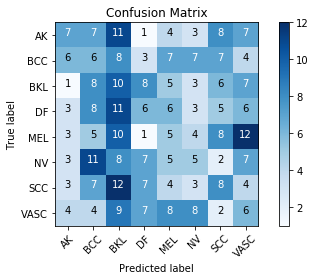

In [0]:
# Define the labels of the class indices. These need to match the 
# order shown above.
#cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']
cm_plot_labels = ['AK' , 'BCC' , 'BKL' , 'DF' , 'MEL' , 'NV' , 'SCC' , 'VASC']
#cm_plot_labels = [ 'MEL', 'NV']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

## Generate the Classification Report

In [0]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

cm_plot_labels = ['AK', 'BCC','BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

In [0]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

## Confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4,5,6,7])

## jaccard_score

In [0]:
from sklearn.metrics import jaccard_score
jaccard_score(y_true, y_pred, average=None)

## ROC AUC

Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)



1.   y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers). For binary y_true, y_score is supposed to be the score of the class with greater label.




In [0]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, 0)


In [0]:
from sklearn.preprocessing import label_binarize
# 3 classes to classify
n_classes = 3

# Binarize the output
y_test = label_binarize(y, classes=[0, 1, 2,3,4,5,6,7])
n_classes = y.shape[1]


In [0]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# # Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

# colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(i, roc_auc[i]))

# plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
# plt.legend(loc="lower right")
# plt.show()


# Upload the model to drive

In [0]:
#!cp 'densenet.h5' -d 'drive/My Drive/densenetfull-.h5'
#sepecifier information in the name

In [0]:
import os

for dirname, dirnames, filenames in os.walk('.'):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        print(os.path.join(dirname, subdirname))

    # print path to all filenames.
    for filename in filenames:
        print(os.path.join(dirname, filename))

    # Advanced usage:
    # editing the 'dirnames' list will stop os.walk() from recursing into there.
    if '.git' in dirnames:
        # don't go into any .git directories.
        dirnames.remove('.git')

In [0]:
n = 0 

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#train_fld = os.listdir (train_dir2)
train_fld =['MEL', 'BKL', 'BCC', 'SCC', 'VASC', 'DF', 'AK','NV']
#train_fld =['SCC', 'VASC', 'DF', 'AK']
fullist = []
temp_img = []
for subfld in train_fld:
    class_dir = os.path.join(train_dir2,subfld)
    imgname = os.listdir (class_dir)
    for nimg in range(len(imgname)):
        temp_img[nimg] = os.path.join(train_dir2,subfld,imgname[nimg])
    fullist.extend(temp_img)
    
image1 = mpimg.imread(fullist[n])
image2 = mpimg.imread(fullist[n+1])
image3 = mpimg.imread(fullist[n+2])
image4 = mpimg.imread(fullist[n+3])
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(image1)
axarr[0,1].imshow(image2)
axarr[1,0].imshow(image3)
axarr[1,1].imshow(image4)


# custom loss functions


In [0]:
def median_weight_class_loss(y_true, y_pred):
  epsilon = tf.constant(value=1e-10)
  weight_sample = np.array([1113,6705,514,327,1099,115,142])/10015
  weight_sample = 0.05132302/weight_sample
  xent = -tf.reduce_sum(tf.multiply(y_true * tf.log(y_pred + epsilon), weight_sample), axis=1)
  return xent
      
         -tf.reduce_sum(y_true * tf.log(y_pred + epsilon) * weight_sample, axis=1)


In [0]:
def median_weight_class_loss(labels, logits):
  epsilon = tf.constant(value=1e-10)
  logits = logits + epsilon
  softmax = tf.nn.softmax(logits)
  #this is just the number of samples in each class in my dataset divided by the sum of samples 10015.
  weight_sample = np.array([1113,6705,514,327,1099,115,142])/10015
  weight_sample = 0.05132302/weight_sample
  xent = -tf.reduce_sum(tf.multiply(labels * tf.log(softmax + epsilon), weight_sample), axis=1)
  return xent

In [0]:
def focal_loss(labels, logits):
    gamma=2.0
    alpha=4.0
    epsilon = tf.constant(value=1e-9)
    softmax = tf.nn.softmax(logits)
    model_out = tf.add(softmax, epsilon)
    ce = tf.multiply(labels, -tf.log(model_out))

    # FC
    weight = tf.multiply(labels, tf.pow(tf.subtract(1., model_out), gamma))

    # mask 1 class keep it weight as origin 1
    mask = tf.constant([0.0,1.0,0.0,0.0,0.0,0.0,0.0])
    class_1 = tf.multiply(mask, weight)
    weight = tf.add(-class_1+1, weight)

    # multiply median fre
    #weight_sample = np.array([1113,6705,514,327,1099,115,142])/10015
    #weight_sample = 0.05132302/weight_sample
    #weight = tf.multiply(weight, weight_sample)


    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    #reduced_fl = tf.reduce_sum(fl, axis=1, keep_dims=True)
    reduced_fl = tf.reduce_sum(fl, axis=1)
    return reduced_fl

def median_weight_class_loss(labels, logits):
    epsilon = tf.constant(value=1e-10)
    logits = logits + epsilon
    softmax = tf.nn.softmax(logits)
    weight_sample = np.array([1113,6705,514,327,1099,115,142])/10015
    weight_sample = 0.05132302/weight_sample
    xent = -tf.reduce_sum(tf.multiply(labels * tf.log(softmax + epsilon), weight_sample), axis=1)
    return xent



In [0]:
model.add(embedding_layer)
model.add(LSTM(n_hidden, return_sequences=False))
model.add(Dropout(dropout_keep_prob))
model.add(Dense(vocab_size))
model.add(Activation('linear'))
optimizer = RMSprop(lr=self.lr)


def my_sparse_categorical_crossentropy(y_true, y_pred):
    return K.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

model.compile(optimizer=optimizer,loss=my_sparse_categorical_crossentropy)

I think I have found a solution

First, I change the activation layer to linear such that I receive logits as outlined by @loannis Nasios.

Second, to still get the sparse_categorical_crossentropy as a loss function, I define my own loss function, setting the from_logits parameter to true.